<center><a target="_blank" href="https://academy.constructor.org/">
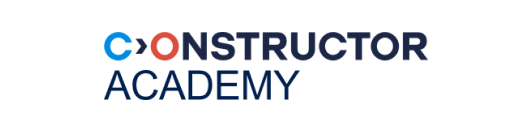</a> </center>
<hr />

# <h1 align="center"> Feed-forward NNs for Structured Data Classification </h1>

<hr />
<center>Constructor Academy, 2024</center>

## Introduction

The idea of this exercise is to learn how to do structured data classification using neural networks, starting from a raw
CSV file. Our data includes both numerical and categorical features.

### The dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Key Objectives - Day 1


1. Your key task is to perform a binary classification problem to predict heart disease based on the given data by splitting it into train-valid-test datasets

2. You will build a variety of dense neural network models starting from simple 1-layer NNs to 2 and 3 layer dense NNs

3. You will also plot learning curves to visualize training performance over epochs

4. You will also evaluate the performance of the models on the test dataset

5. You will also build a model using class weights to tackle class imbalance



## Load Dependencies

In [26]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [27]:
tf.random.set_seed(42)

## Load the dataset

Let's download the data and load it into a Pandas dataframe:

In [28]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):

In [29]:
df.shape

(303, 14)

Here's a preview of a few samples:

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [31]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [32]:
df.ca.unique()

array([0, 3, 2, 1])

The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

## Check the distribution of the target column

In [33]:
df.target.value_counts()

0    220
1     83
Name: target, dtype: int64

In [34]:
df.thal.value_counts()

normal        168
reversible    115
fixed          18
1               1
2               1
Name: thal, dtype: int64

we have two values in the thal column that has no meaning, so we will remove those rows

In [35]:
df = df[~df.thal.isin(['1','2'])]

## Task 1: Split Dataset into Train, Validation and Test Datasets

Use stratified sampling to ensure similar `target` class distribution in the dataset splits when using `train_test_split()`

Use a split of 60:20:20 for train-valid-test splits
For reproducibility set the `random_state` to `42`

In [36]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='target')
y = df[['target']]

# First split: 60% train, 40% temporary test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, random_state=42, test_size=0.4, stratify=y
)

# Second split of the temporary test set: 50% valid, 50% test
# Which correspond to 20% of the original dataset each
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, random_state=42, test_size=0.5, stratify=y_temp
)

In [37]:
X_train.shape, X_valid.shape, X_test.shape

((180, 13), (60, 13), (61, 13))

Due to the dataset not being divisible evenly by the desired 60:20:20 split, the final distribution results in 180 samples for training, 60 for validation, and 61 for testing. This minor discrepancy is a common occurrence in data splitting when dealing with indivisible totals. It is considered acceptable, as the impact on model performance and evaluation is negligible. Thus, we proceed with the split as-is, ensuring that our model training and validation phases are not significantly affected by this slight imbalance.

In [38]:
y_train.value_counts()

target
0         130
1          50
dtype: int64

In [39]:
y_valid.value_counts()

target
0         44
1         16
dtype: int64

In [40]:
y_test.value_counts()

target
0         44
1         17
dtype: int64

In [41]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [42]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.571429,0.677741,3.126246,131.684385,246.817276,0.146179,0.996678,149.308970,0.328904,1.061462,1.594684,0.677741,0.275748
std,9.041702,0.468120,1.008634,17.709415,52.186619,0.353874,0.988259,22.953015,0.470597,1.167295,0.617931,0.937623,0.447634
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,242.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,165.000000,1.000000,1.600000,2.000000,1.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


## Task 2: Data Pre-processing

Recall the data pre-processing you had learnt during the ML week! Perform the following tasks to have clean and pre-processed datasets for your training, validation and test datasets.

Key Steps:

1. One-hot encode categorical data
2. Standard Scaling numerical data
3. Combine categorical and numeric data together into a single dataframe \ numpy array

Hints: Leverage code from [here](https://colab.research.google.com/drive/1ISCLIEkrLhtNo0r-hAmA6fYA6nkB1o59) [pre-processing parts only]

In [43]:
cat_feats = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'thal']
num_feats = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope']

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [45]:
categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(sparse_output=False,
                                                                   handle_unknown="ignore").set_output(transform="pandas"))
                                          ])

numeric_transformer = Pipeline(steps=[
                                      ("scaler", StandardScaler().set_output(transform="pandas"))
                                      ])

preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer,
                                                       num_feats),
                                               ("cat", categorical_transformer,
                                                       cat_feats)
                                               ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak', 'slope']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca',
                                  'thal'])])

In [46]:
X_train_proc = preprocessor.fit_transform(X_train)
X_valid_proc = preprocessor.transform(X_valid)
X_test_proc = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

X_train_proc = pd.DataFrame(X_train_proc, columns=feature_names)
X_valid_proc = pd.DataFrame(X_valid_proc, columns=feature_names)
X_test_proc = pd.DataFrame(X_test_proc, columns=feature_names)

In [47]:
X_train_proc.head()

,num__age,num__trestbps,num__chol,num__thalach,num__oldpeak,num__slope,cat__sex_0,cat__sex_1,cat__cp_0,cat__cp_1,...,cat__restecg_2,cat__exang_0,cat__exang_1,cat__ca_0,cat__ca_1,cat__ca_2,cat__ca_3,cat__thal_fixed,cat__thal_normal,cat__thal_reversible
0,-1.083146,-0.903756,0.253956,1.585937,-0.914960,-0.950923,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.522576,-0.628127,-0.050537,0.579070,-0.026039,-0.950923,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.410462,-1.179385,-1.363665,-1.128226,-0.430094,-0.950923,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.047020,2.679417,1.490960,0.228855,-0.914960,-0.950923,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.934906,-0.076870,1.586114,-0.734234,0.539638,-0.950923,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [48]:
X_train_proc.shape

(180, 27)

## Task 3: Training simple 1-layer Neural Networks

Run the following experiments separately to train 1-layer neural networks, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment


### Experiment 1 - Basic NN:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- learning rate: 0.001
- optimizer is SGD
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- epochs: 500
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

<br>

### Experiment 2 - NN with Adam Optimizer:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- learning rate: 0.001
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- epochs: 500
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

<br>

### Experiment 3 - Experiment with lower Learning Rate:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- epochs: 500
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

<br>

### Experiment 4 - Experiment with Early Stopping:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports




### Hint: Utility function for plotting learning curves

You can use the following function to plot the learning curves after training.

Remember to do the following during training:

```
history = model.fit(.......)

# to plot the curves
plot_metrics(history)
```

In [49]:
import matplotlib.pyplot as plt


def plot_metrics(history, experiment_name=None):
    keys = history.history.keys()
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    if experiment_name:
        plt.suptitle(experiment_name)
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        metric_name = [item for item in keys if metric in item and 'val_' + metric not in item][0]
        val_metric_name = [item for item in keys if 'val_' + metric in item][0]

        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric_name], color='b', label='Train')
        plt.plot(history.epoch, history.history[val_metric_name], color='r', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()

## Complete Task 3 Below

### Experiment 1 - Basic NN:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- learning rate: 0.001
- optimizer is SGD
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- epochs: 500
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [50]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-3

model1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model1.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                896       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 929 (3.63 KB)
Trainable params: 929 (3.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


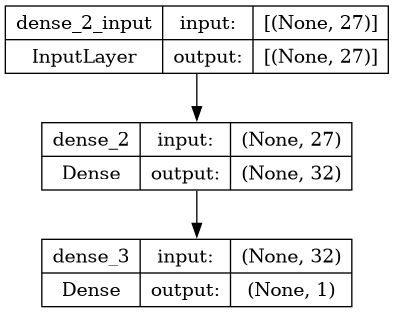

In [51]:
tf.keras.utils.plot_model(model1, show_shapes=True)

In [52]:
EPOCHS = 500
BATCH_SIZE=32

history = model1.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    verbose=1)

Epoch 1/500


2024-06-17 12:33:27.013945: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-17 12:33:27.437929: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff7241f7e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-17 12:33:27.437966: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A3000 Laptop GPU, Compute Capability 8.6


1/6 [====>.........................] - ETA: 21s - loss: 0.7251 - accuracy: 0.6250 - precision: 0.0000e+00 - recall: 0.0000e+00

2024-06-17 12:33:27.893814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1718620407.937947   67409 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 [==============================] - 5s 120ms/step - loss: 0.6861 - accuracy: 0.6222 - precision: 0.0500 - recall: 0.0200 - val_loss: 0.6807 - val_accuracy: 0.6500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
6/6 [==============================] - 0s 14ms/step - loss: 0.6838 - accuracy: 0.6278 - precision: 0.0526 - recall: 0.0200 - val_loss: 0.6781 - val_accuracy: 0.6500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
6/6 [==============================] - 0s 15ms/step - loss: 0.6817 - accuracy: 0.6333 - precision: 0.0556 - recall: 0.0200 - val_loss: 0.6757 - val_accuracy: 0.6500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/500
6/6 [==============================] - 0s 16ms/step - loss: 0.6796 - accuracy: 0.6333 - precision: 0.0556 - recall: 0.0200 - val_loss: 0.6732 - val_accuracy: 0.6500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/500
6/6 [==============================] - 0s 14ms/step - loss: 0.6774 - accuracy: 

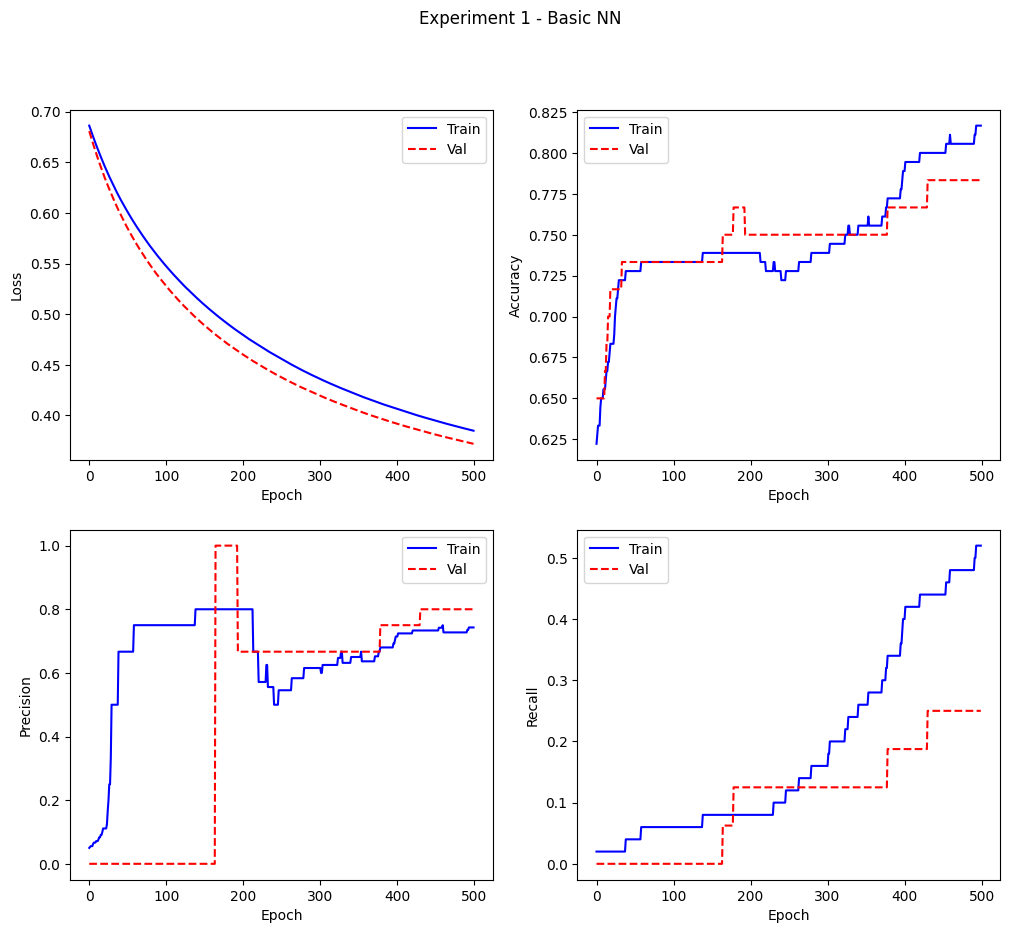

In [53]:
plot_metrics(history, experiment_name="Experiment 1 - Basic NN")

从你提供的四个图表中，你正在可视化模型的训练和验证过程，分别包括损失（loss）、准确率（accuracy）、精度（precision）和召回率（recall）。下面我会逐一解释这些图表以及它们的含义：

### 1. **Loss 曲线（左上图）**
- **横轴**：表示训练的迭代次数（epochs）。
- **纵轴**：表示损失值（loss），即模型在训练和验证数据上的损失。
- **蓝色实线（Train）**：表示训练集上的损失随训练过程逐渐减少。
- **红色虚线（Val）**：表示验证集上的损失。

- 损失值（loss） 是模型根据 X_train 生成预测值（y_pred），然后将 y_pred 和 y_train 进行比较，计算损失值。

**解释**：
- **训练集和验证集的损失都在下降**，说明模型在逐渐学习，误差在减小。
- 如果训练集的损失下降得比验证集快很多，且验证集的损失在某一时刻开始上升，那可能意味着模型过拟合（即在训练集上表现好，但在验证集上表现不好）。从图中来看，目前没有明显的过拟合迹象，训练和验证损失曲线都在平稳下降。

### 2. **Accuracy 曲线（右上图）**
- **横轴**：训练的迭代次数。
- **纵轴**：模型的准确率（accuracy）。
- **蓝色实线（Train）**：训练集上的准确率。
- **红色虚线（Val）**：验证集上的准确率。

**解释**：
- **两条曲线都在上升**，这表明随着训练的进行，模型在训练集和验证集上的准确率都在提高，说明模型在变得越来越好。
- **验证集准确率趋于稳定**，且与训练集准确率接近，这是一个好的信号，表明模型在验证集上的表现接近训练集，过拟合现象不明显。

### 3. **Precision 曲线（左下图）**
- **横轴**：训练的迭代次数。
- **纵轴**：精度（precision），即在模型预测为正类的样本中，实际为正类的比例。
- **蓝色实线（Train）**：训练集上的精度。
- **红色虚线（Val）**：验证集上的精度。

**解释**：
- 精度在前期波动比较大，特别是验证集的精度在训练过程中出现了一些不稳定的情况（中间有较大波动），这可能是由于验证集样本较少，或者数据不平衡导致。
- 在后期（300 epochs 之后），精度逐渐稳定上升。**但仍有一定波动**，可能需要进一步调整模型或者优化超参数。

### 4. **Recall 曲线（右下图）**
- **横轴**：训练的迭代次数。
- **纵轴**：召回率（recall），即在所有实际为正类的样本中，模型正确预测为正类的比例。
- **蓝色实线（Train）**：训练集上的召回率。
- **红色虚线（Val）**：验证集上的召回率。

**解释**：
- 从召回率来看，训练集和验证集都在逐渐上升，说明模型能够逐渐更好地捕获正类样本。
- 不过，召回率整体较低，表明模型在捕捉正类样本时还有待提升（正类样本的检出率较低）。这可能需要进一步调整数据集、模型或者考虑其他平衡策略。

### 总体结论：
1. **损失和准确率**：模型的损失在不断减少，准确率在不断提升，训练集和验证集表现接近，模型没有明显过拟合。
2. **精度和召回率的波动**：精度和召回率在训练初期波动较大，但在后期趋于稳定，表明模型的性能在逐渐提升。不过，召回率整体较低，可能需要进一步调整。

你可以继续观察模型在后续训练中的表现，或者通过调参、添加正则化、调整数据集等方式进一步优化模型的精度和召回率。

如果你有进一步的疑问，随时告知！

### Experiment 2 - NN with Adam Optimizer:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- learning rate: 0.001
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- epochs: 500
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


In [54]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-3

model2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                896       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 929 (3.63 KB)
Trainable params: 929 (3.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
EPOCHS = 500
BATCH_SIZE=32

history2 = model2.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    verbose=1)

Epoch 1/500


2024-06-17 12:34:14.488953: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


6/6 [==============================] - 1s 46ms/step - loss: 0.8346 - accuracy: 0.2778 - precision_1: 0.0918 - recall_1: 0.1800 - val_loss: 0.7703 - val_accuracy: 0.4167 - val_precision_1: 0.2121 - val_recall_1: 0.4375
Epoch 2/500
6/6 [==============================] - 0s 15ms/step - loss: 0.7600 - accuracy: 0.4611 - precision_1: 0.1385 - recall_1: 0.1800 - val_loss: 0.7013 - val_accuracy: 0.5667 - val_precision_1: 0.2500 - val_recall_1: 0.3125
Epoch 3/500
6/6 [==============================] - 0s 18ms/step - loss: 0.7007 - accuracy: 0.5889 - precision_1: 0.1842 - recall_1: 0.1400 - val_loss: 0.6450 - val_accuracy: 0.6833 - val_precision_1: 0.3333 - val_recall_1: 0.1875
Epoch 4/500
6/6 [==============================] - 0s 23ms/step - loss: 0.6488 - accuracy: 0.6500 - precision_1: 0.2174 - recall_1: 0.1000 - val_loss: 0.6003 - val_accuracy: 0.6833 - val_precision_1: 0.2000 - val_recall_1: 0.0625
Epoch 5/500
6/6 [==============================] - 0s 19ms/step - loss: 0.6063 - accuracy: 0

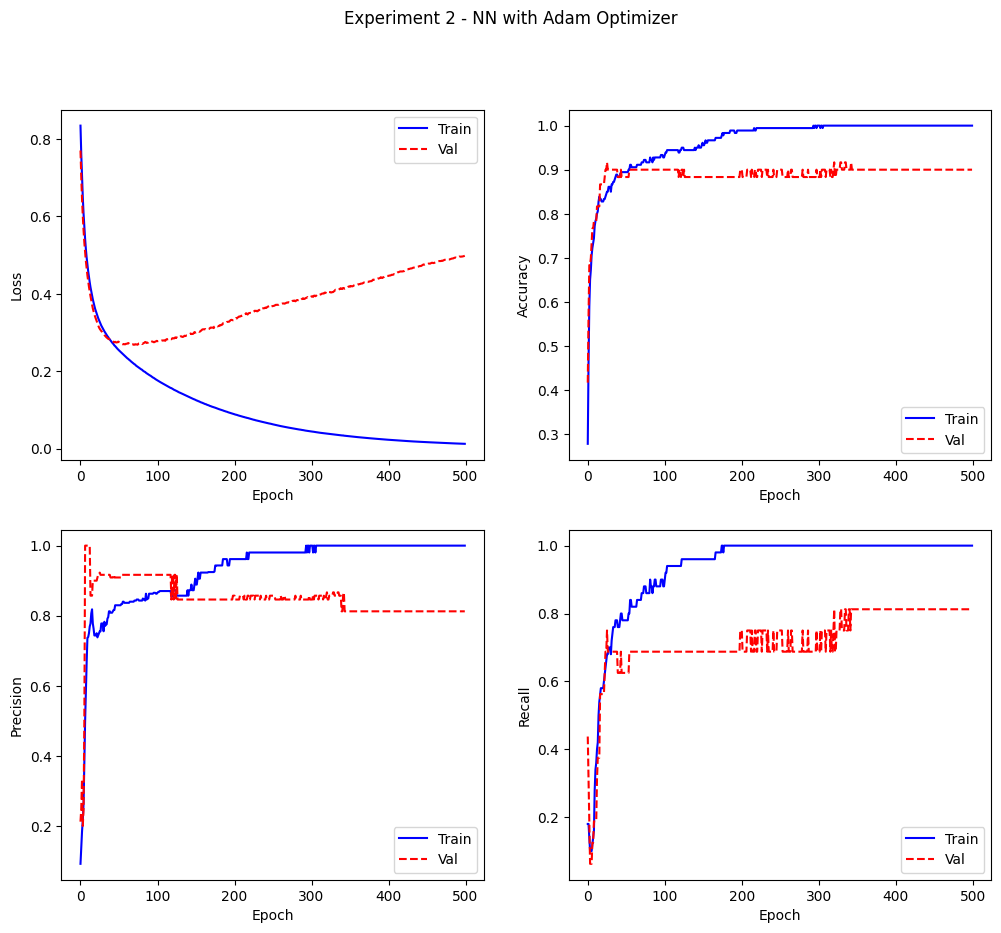

In [56]:
plot_metrics(history2, experiment_name="Experiment 2 - NN with Adam Optimizer")

从你提供的图来看，这四个图表分别是 **Loss（损失）**、**Accuracy（准确率）**、**Precision（精度）** 和 **Recall（召回率）** 的训练和验证曲线。以下是逐个图表的详细解释：

### 1. **Loss 曲线（左上图）**
- **横轴**：训练的迭代次数（Epochs）。
- **纵轴**：损失值（Loss）。
- **蓝色实线（Train）**：训练集上的损失。
- **红色虚线（Val）**：验证集上的损失。

#### 分析：
- **训练损失**：从图中可以看出，训练集的损失随着训练的进行快速下降，表明模型正在学习，并且在训练集上的表现越来越好。
- **验证损失**：在前几十个 epoch 后，验证损失在减少一段时间后开始上升，这可能是 **过拟合** 的迹象。即模型在训练集上表现良好，但在验证集上表现不如训练集，说明模型在过度拟合训练数据，泛化能力可能较差。

### 2. **Accuracy 曲线（右上图）**
- **横轴**：训练的迭代次数（Epochs）。
- **纵轴**：准确率（Accuracy）。
- **蓝色实线（Train）**：训练集上的准确率。
- **红色虚线（Val）**：验证集上的准确率。

#### 分析：
- **训练准确率**：训练集的准确率接近 1.0，说明模型在训练集上表现极好。
- **验证准确率**：验证集的准确率在 50 个 epoch 后趋于稳定，并接近 0.85。这表明虽然模型在训练集上几乎达到了完美，但在验证集上却略有不足，这进一步印证了**过拟合**的存在。

### 3. **Precision 曲线（左下图）**
- **横轴**：训练的迭代次数（Epochs）。
- **纵轴**：精度（Precision），即在模型预测为正类的样本中，实际为正类的比例。
- **蓝色实线（Train）**：训练集上的精度。
- **红色虚线（Val）**：验证集上的精度。

#### 分析：
- **训练集精度**：训练集的精度在初期快速上升，并趋近于 1.0。
- **验证集精度**：验证集的精度在初期有波动，并且在 200 个 epoch 后呈现出一些波动，可能是由于数据集较小或者类别不平衡导致的，但精度总体上接近 0.85。
- 验证集的精度在某些时刻波动较大，这表明模型在不同阶段预测正类的能力并不稳定。

### 4. **Recall 曲线（右下图）**
- **横轴**：训练的迭代次数（Epochs）。
- **纵轴**：召回率（Recall），即在所有实际为正类的样本中，模型正确预测为正类的比例。
- **蓝色实线（Train）**：训练集上的召回率。
- **红色虚线（Val）**：验证集上的召回率。

#### 分析：
- **训练集召回率**：训练集的召回率在前期快速上升，并接近 1.0。
- **验证集召回率**：验证集的召回率在 50 个 epoch 后趋于稳定，并保持在 0.8 左右。召回率较高，表明模型能较好地识别验证集中的正类样本，但相对于训练集的表现，依然有些差距。

---

### 总体结论：

1. **过拟合**：从 **Loss 曲线** 可以看出，模型在训练集上的损失一直在下降，但验证集的损失在某个阶段开始上升，表明模型在训练集上表现得非常好，但在验证集上出现了过拟合现象。**过拟合** 意味着模型对训练数据的细节学习得太多，无法很好地泛化到未见过的验证数据上。

2. **准确率差异**：从 **Accuracy 曲线** 可以看到，训练集的准确率接近 1.0，但验证集的准确率停留在 0.85 左右，进一步表明了过拟合。

3. **精度和召回率的波动**：验证集的 **Precision** 和 **Recall** 在中后期出现波动，可能是由于模型在不同类别上的表现不稳定。这可能是由于验证集样本较少或类别不平衡导致的。

### 优化建议：

1. **早停（Early Stopping）**：在图中可以看到过拟合发生在 50 个 epoch 左右，你可以通过调节早停的 patience 参数，提前停止训练，从而防止过拟合。
   
2. **正则化**：可以考虑在模型中加入正则化项（如 L2 正则化）或者 Dropout 层，减少过拟合现象。

3. **数据扩充**：如果数据量较小，可以考虑对训练数据进行扩充，提升模型的泛化能力。

通过这些优化策略，可能可以进一步提高模型在验证集上的表现，并减少过拟合现象。

如果有更多问题，请告诉我！

### Experiment 3 - Experiment with lower Learning Rate:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- epochs: 500
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


In [57]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4

model3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                896       
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 929 (3.63 KB)
Trainable params: 929 (3.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
EPOCHS = 500
BATCH_SIZE=32

history3 = model3.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    verbose=1)

Epoch 1/500
6/6 [==============================] - 1s 55ms/step - loss: 0.6731 - accuracy: 0.6222 - precision_2: 0.3125 - recall_2: 0.3000 - val_loss: 0.6933 - val_accuracy: 0.5833 - val_precision_2: 0.2632 - val_recall_2: 0.3125
Epoch 2/500
6/6 [==============================] - 0s 21ms/step - loss: 0.6691 - accuracy: 0.6222 - precision_2: 0.3125 - recall_2: 0.3000 - val_loss: 0.6890 - val_accuracy: 0.5833 - val_precision_2: 0.2632 - val_recall_2: 0.3125
Epoch 3/500
6/6 [==============================] - 0s 21ms/step - loss: 0.6654 - accuracy: 0.6222 - precision_2: 0.3043 - recall_2: 0.2800 - val_loss: 0.6848 - val_accuracy: 0.6000 - val_precision_2: 0.2778 - val_recall_2: 0.3125
Epoch 4/500
6/6 [==============================] - 0s 17ms/step - loss: 0.6616 - accuracy: 0.6222 - precision_2: 0.3043 - recall_2: 0.2800 - val_loss: 0.6808 - val_accuracy: 0.6000 - val_precision_2: 0.2778 - val_recall_2: 0.3125
Epoch 5/500
6/6 [==============================] - 0s 17ms/step - loss: 0.6579 -

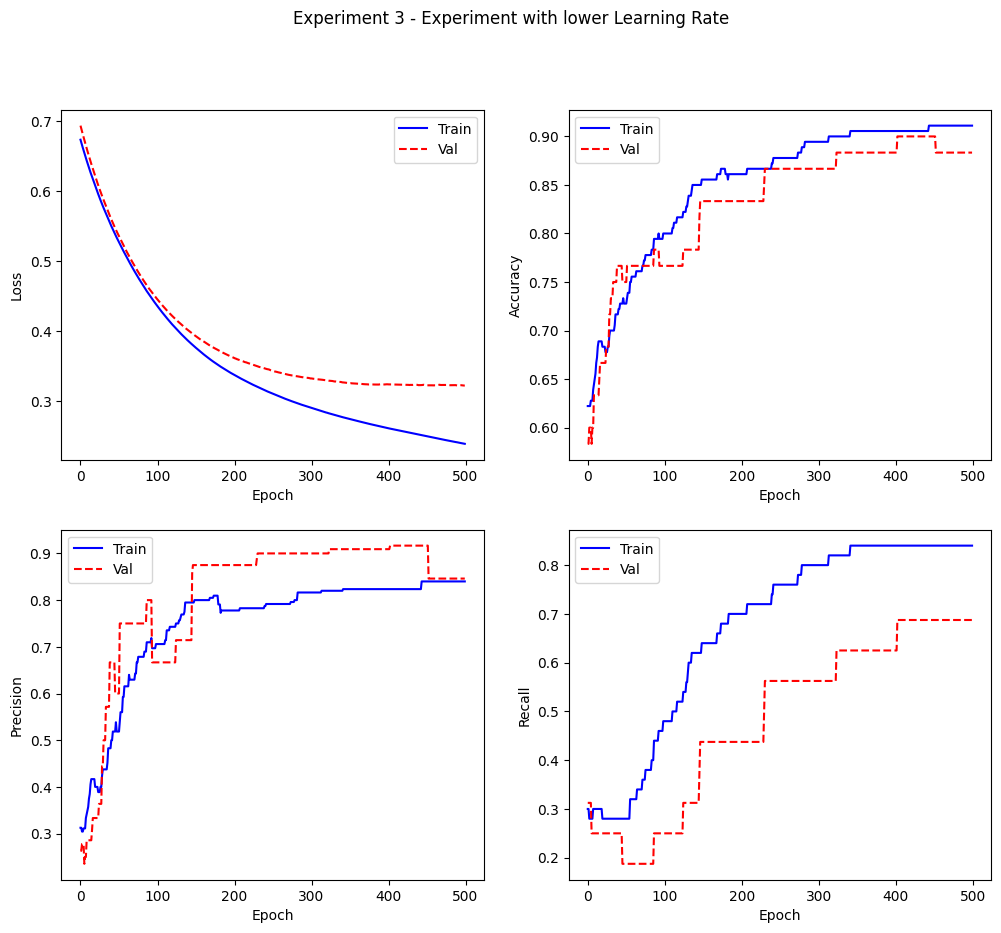

In [59]:
plot_metrics(history3, experiment_name="Experiment 3 - Experiment with lower Learning Rate")

### Experiment 4 - Experiment with Early Stopping:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [60]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4

model4 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                896       
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 929 (3.63 KB)
Trainable params: 929 (3.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history4 = model4.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    verbose=1)

Epoch 1/10000
6/6 [==============================] - 1s 53ms/step - loss: 0.7095 - accuracy: 0.4944 - precision_3: 0.2887 - recall_3: 0.5600 - val_loss: 0.6833 - val_accuracy: 0.5000 - val_precision_3: 0.2812 - val_recall_3: 0.5625
Epoch 2/10000
6/6 [==============================] - 0s 16ms/step - loss: 0.7027 - accuracy: 0.5278 - precision_3: 0.3077 - recall_3: 0.5600 - val_loss: 0.6763 - val_accuracy: 0.5167 - val_precision_3: 0.2903 - val_recall_3: 0.5625
Epoch 3/10000
6/6 [==============================] - 0s 18ms/step - loss: 0.6963 - accuracy: 0.5500 - precision_3: 0.3176 - recall_3: 0.5400 - val_loss: 0.6695 - val_accuracy: 0.5500 - val_precision_3: 0.3103 - val_recall_3: 0.5625
Epoch 4/10000
6/6 [==============================] - 0s 26ms/step - loss: 0.6899 - accuracy: 0.5778 - precision_3: 0.3375 - recall_3: 0.5400 - val_loss: 0.6630 - val_accuracy: 0.5667 - val_precision_3: 0.3214 - val_recall_3: 0.5625
Epoch 5/10000
6/6 [==============================] - 0s 32ms/step - loss

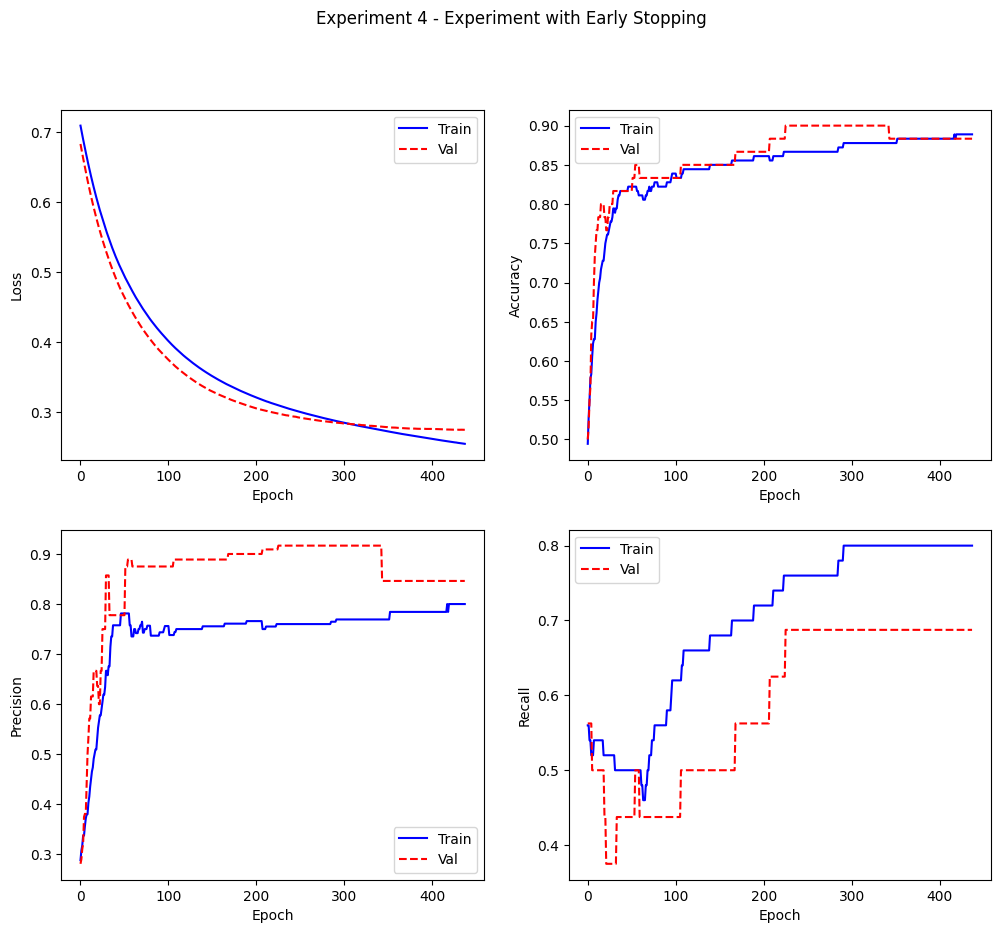

In [62]:
plot_metrics(history4, experiment_name="Experiment 4 - Experiment with Early Stopping")

### Evaluating performance of Models Expt 1 - 4

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

def get_prediction_labels(model, dataset):
  pred_probas = model.predict(dataset)
  pred_probas = pred_probas.ravel()
  pred_labels = [1 if prob > 0.5 else 0 for prob in pred_probas]
  return pred_labels

def display_performance_metrics(actuals, predictions):
  print('Classification Report:')
  print(classification_report(actuals, predictions))
  print('Confusion Matrix:')
  return pd.DataFrame(confusion_matrix(actuals, predictions))

In [64]:
y_pred1 = get_prediction_labels(model1, X_test_proc)
display_performance_metrics(y_test, y_pred1)

2/2 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        44
           1       0.80      0.47      0.59        17

    accuracy                           0.82        61
   macro avg       0.81      0.71      0.74        61
weighted avg       0.82      0.82      0.80        61

Confusion Matrix:


,0,1
0,42,2
1,9,8


In [65]:
y_pred2 = get_prediction_labels(model2, X_test_proc)
display_performance_metrics(y_test, y_pred2)

2/2 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        44
           1       0.67      0.47      0.55        17

    accuracy                           0.79        61
   macro avg       0.74      0.69      0.71        61
weighted avg       0.77      0.79      0.77        61

Confusion Matrix:


,0,1
0,40,4
1,9,8


In [66]:
y_pred3 = get_prediction_labels(model3, X_test_proc)
display_performance_metrics(y_test, y_pred3)

2/2 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        44
           1       0.67      0.35      0.46        17

    accuracy                           0.77        61
   macro avg       0.73      0.64      0.66        61
weighted avg       0.75      0.77      0.74        61

Confusion Matrix:


,0,1
0,41,3
1,11,6


In [67]:
y_pred4 = get_prediction_labels(model4, X_test_proc)
display_performance_metrics(y_test, y_pred4)

2/2 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        44
           1       0.75      0.53      0.62        17

    accuracy                           0.82        61
   macro avg       0.79      0.73      0.75        61
weighted avg       0.81      0.82      0.81        61

Confusion Matrix:


,0,1
0,41,3
1,8,9


## Task 4: Training deep multi-layer Neural Networks

Run the following experiments separately to train multi-layer neural networks, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment


### Experiment 1 -  2-layer NN:  
- __2-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

<br>

### Experiment 2 -  3-layer NN:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


## Complete Task 4 Below

### Experiment 1 -  2-layer NN:  
- __2-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [68]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4

model5 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                896       
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1985 (7.75 KB)
Trainable params: 1985 (7.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history5 = model5.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    verbose=1)

Epoch 1/10000
6/6 [==============================] - 1s 56ms/step - loss: 0.8627 - accuracy: 0.3111 - precision_4: 0.2849 - recall_4: 0.9800 - val_loss: 0.8837 - val_accuracy: 0.3167 - val_precision_4: 0.2807 - val_recall_4: 1.0000
Epoch 2/10000
6/6 [==============================] - 0s 26ms/step - loss: 0.8481 - accuracy: 0.3167 - precision_4: 0.2865 - recall_4: 0.9800 - val_loss: 0.8683 - val_accuracy: 0.3167 - val_precision_4: 0.2807 - val_recall_4: 1.0000
Epoch 3/10000
6/6 [==============================] - 0s 21ms/step - loss: 0.8346 - accuracy: 0.3167 - precision_4: 0.2865 - recall_4: 0.9800 - val_loss: 0.8535 - val_accuracy: 0.3167 - val_precision_4: 0.2807 - val_recall_4: 1.0000
Epoch 4/10000
6/6 [==============================] - 0s 19ms/step - loss: 0.8210 - accuracy: 0.3167 - precision_4: 0.2840 - recall_4: 0.9600 - val_loss: 0.8396 - val_accuracy: 0.3333 - val_precision_4: 0.2857 - val_recall_4: 1.0000
Epoch 5/10000
6/6 [==============================] - 0s 20ms/step - loss

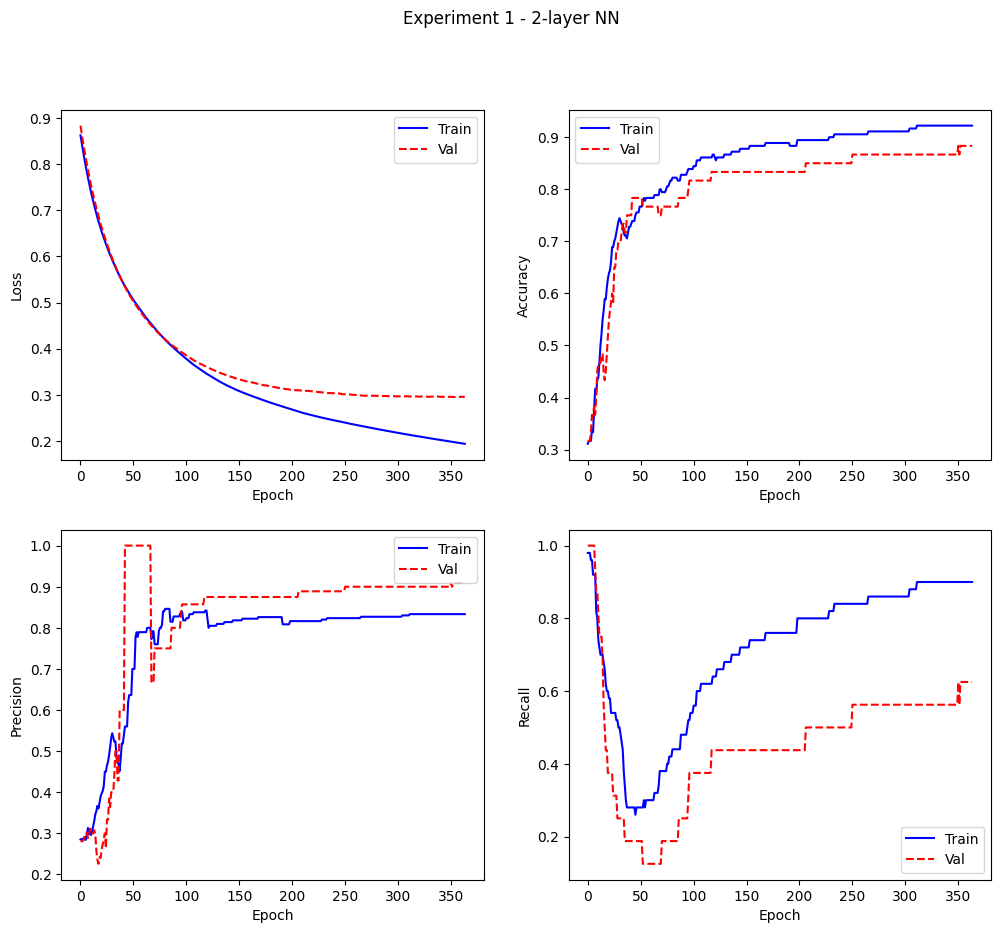

In [70]:
plot_metrics(history5, experiment_name="Experiment 1 - 2-layer NN")

In [71]:
y_pred5 = get_prediction_labels(model5, X_test_proc)
display_performance_metrics(y_test, y_pred5)

2/2 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        44
           1       0.73      0.47      0.57        17

    accuracy                           0.80        61
   macro avg       0.77      0.70      0.72        61
weighted avg       0.79      0.80      0.79        61

Confusion Matrix:


,0,1
0,41,3
1,9,8


### Experiment 2 -  3-layer NN:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


In [72]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4


model6 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 32)                896       
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3041 (11.88 KB)
Trainable params: 3041 (11.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history6 = model6.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    verbose=1)

Epoch 1/10000
6/6 [==============================] - 1s 62ms/step - loss: 0.7636 - accuracy: 0.2833 - precision_5: 0.2743 - recall_5: 0.9600 - val_loss: 0.7832 - val_accuracy: 0.2833 - val_precision_5: 0.2632 - val_recall_5: 0.9375
Epoch 2/10000
6/6 [==============================] - 0s 17ms/step - loss: 0.7541 - accuracy: 0.2889 - precision_5: 0.2759 - recall_5: 0.9600 - val_loss: 0.7720 - val_accuracy: 0.2833 - val_precision_5: 0.2632 - val_recall_5: 0.9375
Epoch 3/10000
6/6 [==============================] - 0s 20ms/step - loss: 0.7458 - accuracy: 0.2944 - precision_5: 0.2775 - recall_5: 0.9600 - val_loss: 0.7613 - val_accuracy: 0.2833 - val_precision_5: 0.2632 - val_recall_5: 0.9375
Epoch 4/10000
6/6 [==============================] - 0s 19ms/step - loss: 0.7369 - accuracy: 0.3056 - precision_5: 0.2781 - recall_5: 0.9400 - val_loss: 0.7511 - val_accuracy: 0.2833 - val_precision_5: 0.2632 - val_recall_5: 0.9375
Epoch 5/10000
6/6 [==============================] - 0s 18ms/step - loss

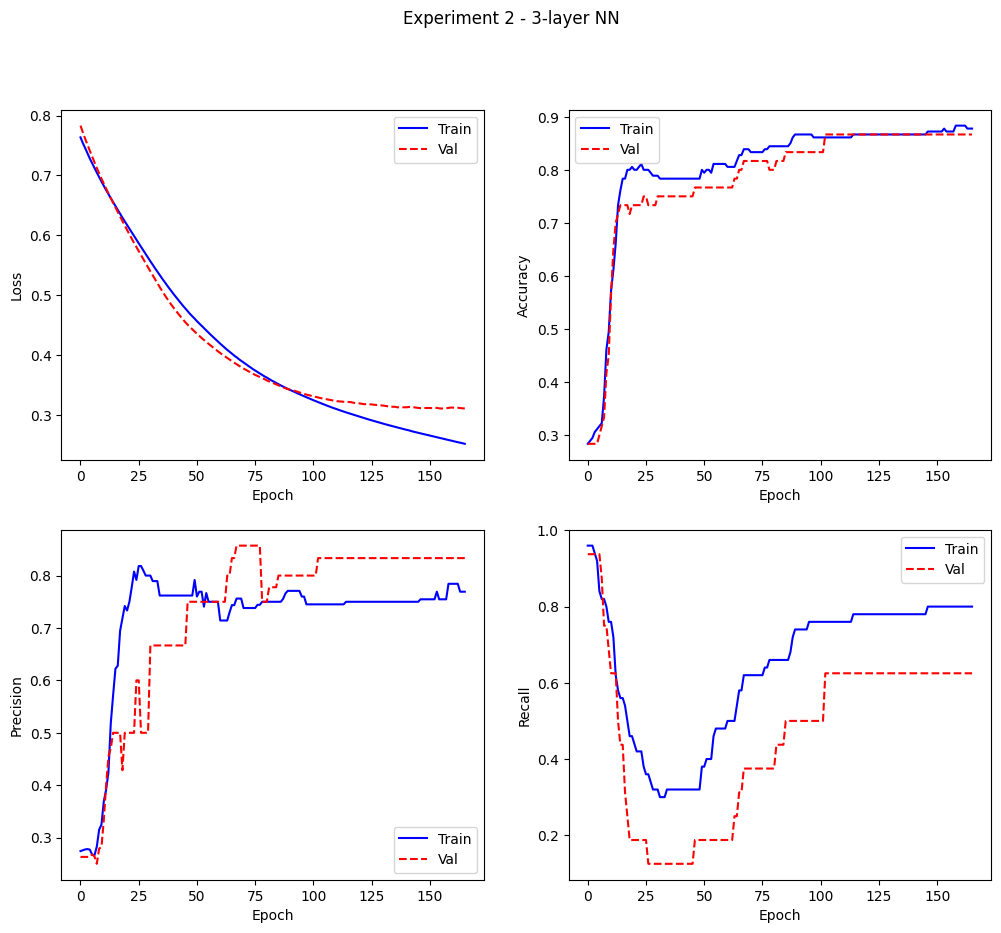

In [74]:
plot_metrics(history6, experiment_name="Experiment 2 - 3-layer NN")

In [75]:
y_pred6 = get_prediction_labels(model6, X_test_proc)
display_performance_metrics(y_test, y_pred6)

2/2 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        44
           1       0.80      0.47      0.59        17

    accuracy                           0.82        61
   macro avg       0.81      0.71      0.74        61
weighted avg       0.82      0.82      0.80        61

Confusion Matrix:


,0,1
0,42,2
1,9,8


## Task 5: Training deep multi-layer Neural Networks with Class Weights to tackle Class Imbalance

We know that our dataset is heavily imbalanced between the two classes, feel free to leverage the`class_weight` parameter in the `model.fit()` function and experiment with your own weights or use [compute class weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) from `sklearn`


Run the following experiment to train multi-layer neural networks, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Play around with the `class_weight` parameter when training


### Experiment 1 -  3-layer NN:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


## Complete Task 5 Below

In [76]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4

model7 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model7.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

model7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 32)                896       
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3041 (11.88 KB)
Trainable params: 3041 (11.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.values), y=y_train.values.ravel())
class_weight = dict(enumerate(class_weight))
class_weight

{0: 0.6923076923076923, 1: 1.8}

In [78]:
EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history7 = model7.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/10000
6/6 [==============================] - 1s 66ms/step - loss: 0.6974 - accuracy: 0.5889 - precision_6: 0.2273 - recall_6: 0.2000 - val_loss: 0.6584 - val_accuracy: 0.6833 - val_precision_6: 0.3846 - val_recall_6: 0.3125
Epoch 2/10000
6/6 [==============================] - 0s 22ms/step - loss: 0.6931 - accuracy: 0.6111 - precision_6: 0.2826 - recall_6: 0.2600 - val_loss: 0.6561 - val_accuracy: 0.7000 - val_precision_6: 0.4167 - val_recall_6: 0.3125
Epoch 3/10000
6/6 [==============================] - 0s 22ms/step - loss: 0.6890 - accuracy: 0.6222 - precision_6: 0.3125 - recall_6: 0.3000 - val_loss: 0.6536 - val_accuracy: 0.7167 - val_precision_6: 0.4545 - val_recall_6: 0.3125
Epoch 4/10000
6/6 [==============================] - 0s 22ms/step - loss: 0.6853 - accuracy: 0.6389 - precision_6: 0.3404 - recall_6: 0.3200 - val_loss: 0.6513 - val_accuracy: 0.7333 - val_precision_6: 0.5000 - val_recall_6: 0.3750
Epoch 5/10000
6/6 [==============================] - 0s 23ms/step - loss

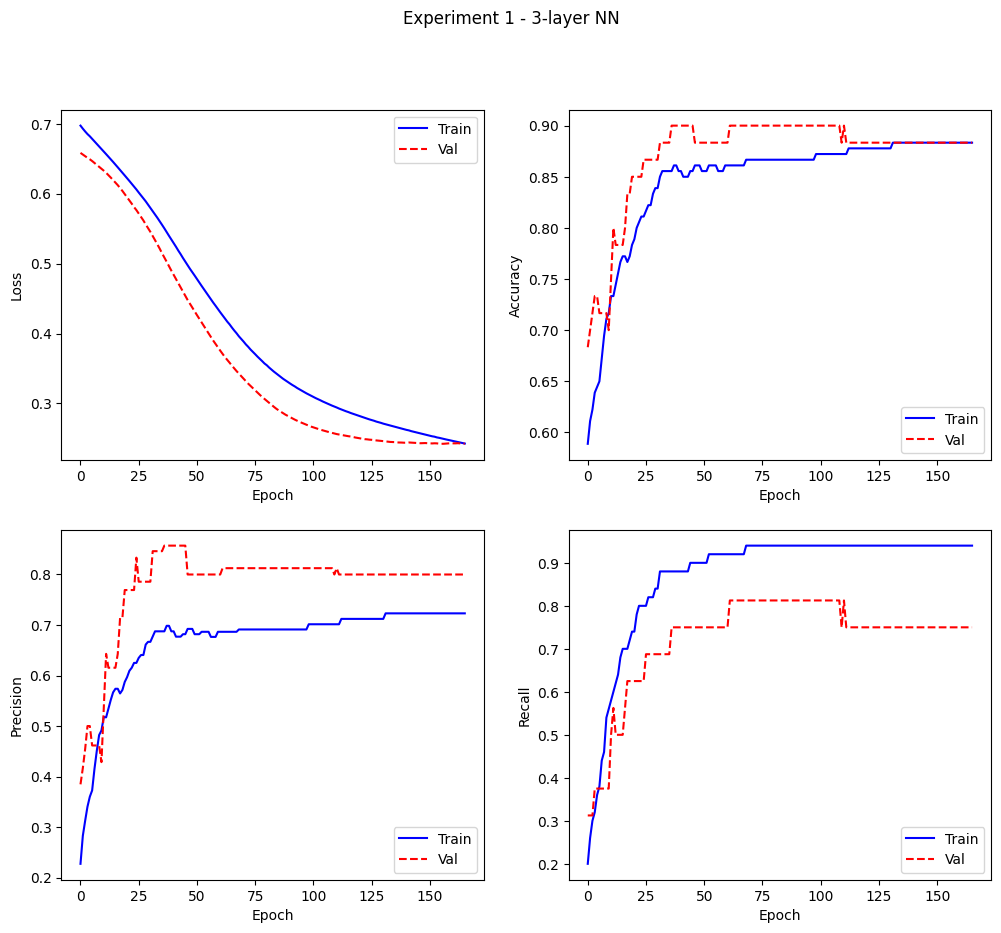

In [79]:
plot_metrics(history7, experiment_name="Experiment 1 - 3-layer NN")

In [80]:
y_pred7 = get_prediction_labels(model7, X_test_proc)
display_performance_metrics(y_test, y_pred7)

2/2 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        44
           1       0.71      0.59      0.65        17

    accuracy                           0.82        61
   macro avg       0.78      0.75      0.76        61
weighted avg       0.81      0.82      0.81        61

Confusion Matrix:


,0,1
0,40,4
1,7,10
